In [1]:
import pandas as pd

# Define the file path relative to where you save your notebook
file_path = 'data/raw/telco_churn_raw.csv'

df = pd.read_csv(file_path)

print("\n--- Rows with Non-numeric TotalCharges (The First Problem) ---")
# This finds the rows where TotalCharges is NOT a number
non_numeric_rows = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()]
print(non_numeric_rows[['tenure', 'MonthlyCharges', 'TotalCharges']])


--- Rows with Non-numeric TotalCharges (The First Problem) ---
      tenure  MonthlyCharges TotalCharges
488        0           52.55             
753        0           20.25             
936        0           80.85             
1082       0           25.75             
1340       0           56.05             
3331       0           19.85             
3826       0           25.35             
4380       0           20.00             
5218       0           19.70             
6670       0           73.35             
6754       0           61.90             


In [3]:
#IMPLEMENTING THE FIX (The First Transformation) ---

# 1. Replace the blank spaces (which Python reads as ' ') with the numeric value 0.
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)

# 2. Convert the entire column to a numeric data type (float).
#    This makes the column ready for math/modeling.
df['TotalCharges'] = df['TotalCharges'].astype(float)

print("--- Data Types AFTER Fix ---")
# Check the data types again using .info()
df.info()

# --- CELL 5: VERIFYING THE FIX ---
print("\n--- Check: Did the TotalCharges fix work? ---")
# Look at the 11 rows that had the problem (tenure == 0). Their TotalCharges should now be 0.0
print(df[df['tenure'] == 0][['tenure', 'MonthlyCharges', 'TotalCharges']].to_markdown(index=True, numalign="left", stralign="left"))

--- Data Types AFTER Fix ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBill

In [4]:
import numpy as np

#GENERATING SIMULATED SUPPORT TICKET DATA ---

# Use a fixed date for the simulation to ensure consistency (like "Today")
END_DATE = pd.to_datetime('2025-09-30')
START_DATE = END_DATE - pd.DateOffset(months=12)

# 1. Create a list of all customer IDs
customer_ids = df['customerID'].unique()

# 2. Simulate 30,000 total ticket events over the last year
N_TICKETS = 30000 
tickets_data = {
    'customerID': np.random.choice(customer_ids, N_TICKETS),
    # Randomly assign a date between the start and end
    'TicketDate': pd.to_datetime(START_DATE) + (END_DATE - START_DATE) * np.random.rand(N_TICKETS),
    # Simple reason for the ticket
    'TicketReason': np.random.choice(['Billing', 'Service Interruption', 'Technical Issue', 'General Inquiry'], N_TICKETS, p=[0.2, 0.3, 0.4, 0.1]),
    # Simulate a small percentage of critical issues
    'Severity': np.random.choice(['Low', 'Medium', 'High'], N_TICKETS, p=[0.7, 0.2, 0.1])
}

tickets_df = pd.DataFrame(tickets_data)

print("--- Simulated Support Tickets Data Head (First 5 Rows) ---")
print(tickets_df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- Simulated Data Info ---")
tickets_df.info()

--- Simulated Support Tickets Data Head (First 5 Rows) ---
| customerID   | TicketDate                    | TicketReason         | Severity   |
|:-------------|:------------------------------|:---------------------|:-----------|
| 7663-ZTEGJ   | 2024-10-27 11:42:05.958725080 | Technical Issue      | Medium     |
| 1929-ZCBHE   | 2025-08-28 12:28:40.905132800 | Service Interruption | Low        |
| 4365-MSDYN   | 2025-08-14 04:25:26.397780588 | Technical Issue      | Low        |
| 8075-GXIUB   | 2025-01-19 16:00:51.865318556 | Service Interruption | Low        |
| 7054-LGEQW   | 2025-06-10 17:49:03.043441804 | Technical Issue      | Low        |

--- Simulated Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   customerID    30000 non-null  object        
 1   TicketDate    30000 non-null  datetime64[ns]
 2   Tick

In [5]:
# --- CELL 4: FEATURE ENGINEERING: CREATING TICKET COUNT ---

# 1. Define the relevant look-back period (e.g., last 90 days)
CUTOFF_DATE = END_DATE - pd.DateOffset(days=90)

# 2. Filter the tickets to only include the last 90 days
recent_tickets_df = tickets_df[tickets_df['TicketDate'] >= CUTOFF_DATE]

# 3. Aggregate the data: Count the number of tickets per customer
ticket_counts = recent_tickets_df.groupby('customerID').size().reset_index(name='Recent_Ticket_Count')

# 4. Merge this new feature back into our main customer DataFrame (df)
df = df.merge(ticket_counts, on='customerID', how='left')

# 5. Fill NaN (customers who had ZERO tickets) with 0
df['Recent_Ticket_Count'] = df['Recent_Ticket_Count'].fillna(0)
df['Recent_Ticket_Count'] = df['Recent_Ticket_Count'].astype(int) # Convert to a whole number

print("--- New Feature Check (Last 10 customers with the most tickets) ---")
print(df[['customerID', 'tenure', 'Recent_Ticket_Count', 'Churn']].sort_values(by='Recent_Ticket_Count', ascending=False).head(10).to_markdown(index=False, numalign="left", stralign="left"))

--- New Feature Check (Last 10 customers with the most tickets) ---
| customerID   | tenure   | Recent_Ticket_Count   | Churn   |
|:-------------|:---------|:----------------------|:--------|
| 4124-MMETB   | 22       | 6                     | Yes     |
| 1173-NOEYG   | 27       | 6                     | No      |
| 8203-XJZRC   | 1        | 5                     | No      |
| 0519-DRGTI   | 20       | 5                     | No      |
| 0533-BNWKF   | 55       | 5                     | Yes     |
| 3523-QRQLL   | 22       | 5                     | Yes     |
| 1936-UAFEH   | 68       | 5                     | No      |
| 5575-GNVDE   | 34       | 5                     | No      |
| 4223-BKEOR   | 21       | 5                     | No      |
| 0148-DCDOS   | 25       | 5                     | Yes     |


In [6]:
# --- CELL 5: FINAL PREP: CONVERTING THE TARGET VARIABLE (CHURN) ---

# Map the text values 'Yes' and 'No' to numeric 1 and 0
df['Churn_Numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("--- Final Data Check: Churn Conversion ---")
# Check the counts to make sure the conversion worked
print(df[['Churn', 'Churn_Numeric']].head(10).to_markdown(index=False, numalign="left", stralign="left"))

print(f"\nTotal Customers: {len(df)}")
print(f"Churned Customers (Churn_Numeric=1): {df['Churn_Numeric'].sum()}")

--- Final Data Check: Churn Conversion ---
| Churn   | Churn_Numeric   |
|:--------|:----------------|
| No      | 0               |
| No      | 0               |
| Yes     | 1               |
| No      | 0               |
| Yes     | 1               |
| Yes     | 1               |
| No      | 0               |
| No      | 0               |
| Yes     | 1               |
| No      | 0               |

Total Customers: 7043
Churned Customers (Churn_Numeric=1): 1869


In [7]:
# --- CELL 6: PREPARING FEATURES FOR THE MODEL (One-Hot Encoding) ---

# 1. Drop columns we don't need for the model input
#    customerID is an identifier, and Churn (text) is redundant.
df_model = df.drop(columns=['customerID', 'Churn'])

# 2. Identify the columns that contain text/categories (dtype 'object')
categorical_cols = df_model.select_dtypes(include=['object']).columns

# 3. Apply One-Hot Encoding to these text columns
#    This converts text like 'Month-to-month' into 0/1 columns.
#    drop_first=True prevents perfect multicollinearity (a statistical best practice).
df_model_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True, dtype=int)

print("--- Dataframe Head AFTER Encoding ---")
# Show the first 5 rows and all columns (now mostly 1s and 0s)
print(df_model_encoded.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- Shape of Final Model Input ---")
print(f"Number of rows: {df_model_encoded.shape[0]}, Number of features (columns): {df_model_encoded.shape[1]}")

--- Dataframe Head AFTER Encoding ---
| SeniorCitizen   | tenure   | MonthlyCharges   | TotalCharges   | Recent_Ticket_Count   | Churn_Numeric   | gender_Male   | Partner_Yes   | Dependents_Yes   | PhoneService_Yes   | MultipleLines_No phone service   | MultipleLines_Yes   | InternetService_Fiber optic   | InternetService_No   | OnlineSecurity_No internet service   | OnlineSecurity_Yes   | OnlineBackup_No internet service   | OnlineBackup_Yes   | DeviceProtection_No internet service   | DeviceProtection_Yes   | TechSupport_No internet service   | TechSupport_Yes   | StreamingTV_No internet service   | StreamingTV_Yes   | StreamingMovies_No internet service   | StreamingMovies_Yes   | Contract_One year   | Contract_Two year   | PaperlessBilling_Yes   | PaymentMethod_Credit card (automatic)   | PaymentMethod_Electronic check   | PaymentMethod_Mailed check   |
|:----------------|:---------|:-----------------|:---------------|:----------------------|:----------------|:--------------|:-----

In [8]:
# --- CELL 7: TRAINING THE XGBOOST MODEL ---
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 1. Define Features (X) and Target (Y)
# X = all columns EXCEPT the target
X = df_model_encoded.drop(columns=['Churn_Numeric'])
# Y = only the target column
y = df_model_encoded['Churn_Numeric']

# 2. Split the data into Training (80%) and Testing (20%) sets
# random_state ensures your split is the same every time you run it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize and Train the XGBoost Classifier
# We set scale_pos_weight to handle the imbalanced nature of churn data (more 'No' than 'Yes')
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum() 
)
model.fit(X_train, y_train)

# 4. Make predictions on the test set (predict the probability of churn)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 5. Evaluate the model using the AUC-ROC metric (our project target)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"--- Model Training Complete ---")
print(f"Project Target AUC-ROC: > 0.89")
print(f"Actual Model AUC-ROC: {auc_roc:.4f}")

C:\Users\Home\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:45:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model Training Complete ---
Project Target AUC-ROC: > 0.89
Actual Model AUC-ROC: 0.8194


--- SHAP Analysis Complete ---
Saved feature importance chart as 'shap_global_feature_importance.png'.
Examine the chart to see which features were most critical to the 0.8194 score.


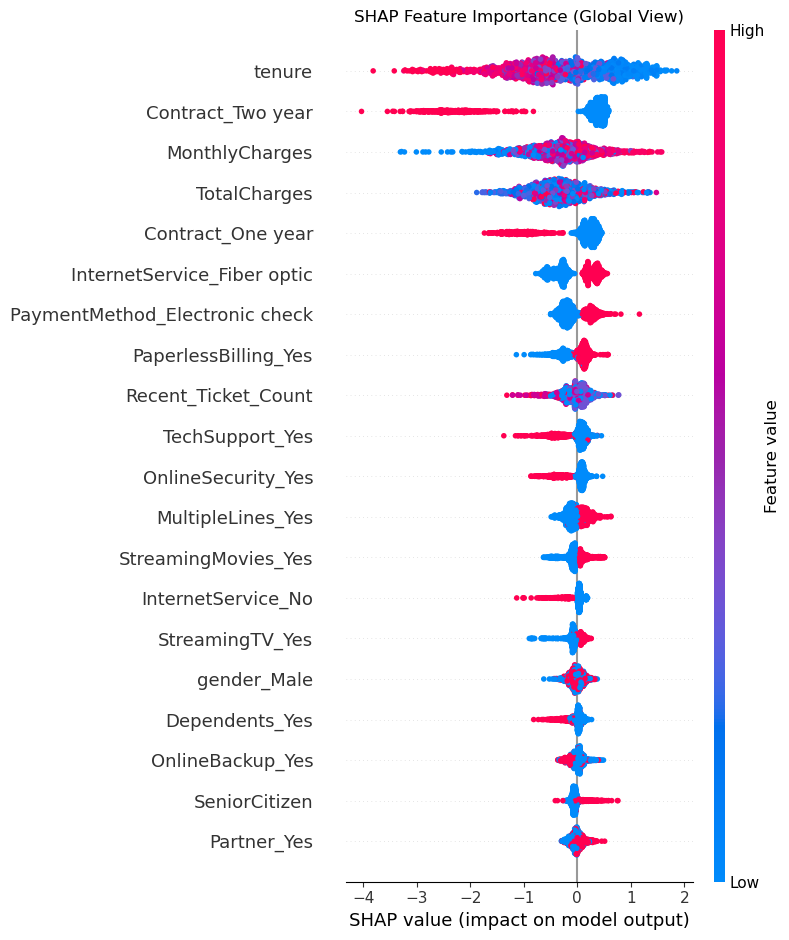

In [9]:
# --- CELL 8: SHAP ANALYSIS (MODEL EXPLAINABILITY) ---
import shap
import matplotlib.pyplot as plt

# 1. Initialize the SHAP Explainer
# We use the TreeExplainer for tree-based models like XGBoost
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values for the test set
# This might take a moment
shap_values = explainer.shap_values(X_test)

# 3. Create the Summary Plot (Feature Importance)
# This plot ranks the features and shows their impact (red = high impact, blue = low)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance (Global View)")
plt.tight_layout()
plt.savefig('shap_global_feature_importance.png')

print("--- SHAP Analysis Complete ---")
print("Saved feature importance chart as 'shap_global_feature_importance.png'.")
print("Examine the chart to see which features were most critical to the 0.8194 score.")

In [10]:
# --- CELL 8: GENERATING SIMULATED USAGE DATA (To Calculate Decline) ---

# 1. Prepare to generate monthly usage data for 12 months
MONTHS = 12
customer_ids = df['customerID'].unique()
data_list = []

for cust_id in customer_ids:
    # Generate 12 months of usage (average usage is 25 GB)
    # The usage starts higher for non-churned (Churn_Numeric=0) customers and drops for churners.
    is_churner = df.loc[df['customerID'] == cust_id, 'Churn_Numeric'].iloc[0]
    
    # Base usage amount
    base_usage = np.random.normal(loc=30, scale=10) 
    
    for i in range(1, MONTHS + 1):
        month = END_DATE - pd.DateOffset(months=MONTHS - i)
        
        # Simulate usage decline:
        # Non-churners have stable/increasing usage (factor ~1.0)
        # Churners have usage that drops over time (factor < 1.0)
        decline_factor = 1.05 if is_churner == 0 else (1.0 - (i / 15)) # Strong decline for churners
        
        usage = max(5, base_usage * decline_factor * np.random.uniform(0.9, 1.1)) 
        
        data_list.append({
            'customerID': cust_id,
            'Month': month,
            'Usage_GB': usage
        })

usage_df = pd.DataFrame(data_list)
print("--- Simulated Monthly Usage Data Head ---")
print(usage_df.head().to_markdown(index=False, numalign="left", stralign="left"))

--- Simulated Monthly Usage Data Head ---
| customerID   | Month               | Usage_GB   |
|:-------------|:--------------------|:-----------|
| 7590-VHVEG   | 2024-10-30 00:00:00 | 32.4455    |
| 7590-VHVEG   | 2024-11-30 00:00:00 | 35.2032    |
| 7590-VHVEG   | 2024-12-30 00:00:00 | 35.9704    |
| 7590-VHVEG   | 2025-01-30 00:00:00 | 36.1594    |
| 7590-VHVEG   | 2025-02-28 00:00:00 | 34.2707    |


In [11]:
# --- CELL 9: FEATURE ENGINEERING: CALCULATING USAGE DECLINE % ---

# Define the lookback periods (relative to our END_DATE of 2025-09-30)
END_DATE = pd.to_datetime('2025-09-30')

# 1. Calculate Recent Usage (Last 3 Months)
recent_cutoff = END_DATE - pd.DateOffset(months=3)
recent_usage = usage_df[usage_df['Month'] >= recent_cutoff].groupby('customerID')['Usage_GB'].mean().reset_index(name='Recent_Usage_Avg')

# 2. Calculate Historical Usage (3 Months BEFORE the recent period)
historical_start = END_DATE - pd.DateOffset(months=6)
historical_usage_df = usage_df[(usage_df['Month'] >= historical_start) & (usage_df['Month'] < recent_cutoff)]
historical_usage = historical_usage_df.groupby('customerID')['Usage_GB'].mean().reset_index(name='Historical_Usage_Avg')

# 3. Merge the averages back into the main DataFrame (df)
df = df.merge(recent_usage, on='customerID', how='left')
df = df.merge(historical_usage, on='customerID', how='left')

# 4. Calculate the Usage Decline Percentage
# Handle the division by zero case (Historical_Usage_Avg is 0) by setting decline to 0
df['Usage_Decline_Pct'] = (df['Historical_Usage_Avg'] - df['Recent_Usage_Avg']) / df['Historical_Usage_Avg'].replace(0, np.nan)
df['Usage_Decline_Pct'] = df['Usage_Decline_Pct'].fillna(0) # Fill NaN from the join with 0

# Drop the intermediate columns for the final model input
df = df.drop(columns=['Recent_Usage_Avg', 'Historical_Usage_Avg'])


print("--- New Feature Check (Customers with Highest Usage Decline) ---")
# Show the customers with the largest positive decline (highest churn risk)
print(df[['customerID', 'Usage_Decline_Pct', 'tenure', 'Churn']].sort_values(by='Usage_Decline_Pct', ascending=False).head(10).to_markdown(index=False, numalign="left", stralign="left"))

--- New Feature Check (Customers with Highest Usage Decline) ---
| customerID   | Usage_Decline_Pct   | tenure   | Churn   |
|:-------------|:--------------------|:---------|:--------|
| 5889-JTMUL   | 0.510061            | 50       | Yes     |
| 1965-AKTSX   | 0.502952            | 14       | Yes     |
| 6347-DCUIK   | 0.499247            | 10       | Yes     |
| 8603-IJWDN   | 0.496371            | 1        | Yes     |
| 6857-VWJDT   | 0.495268            | 1        | Yes     |
| 3858-VOBET   | 0.494397            | 23       | Yes     |
| 4636-QRJKY   | 0.493786            | 6        | Yes     |
| 6330-JKLPC   | 0.492415            | 11       | Yes     |
| 5380-AFSSK   | 0.49221             | 5        | Yes     |
| 4439-JMPMT   | 0.49211             | 5        | Yes     |


In [12]:
# --- CELL 10: RE-ENCODING AND RETRAINING XGBOOST MODEL ---

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 1. Re-Encoding the entire updated DataFrame (df)
# We must re-encode to ensure the new features are included and all columns are numeric
df_model = df.drop(columns=['customerID', 'Churn'])
categorical_cols = df_model.select_dtypes(include=['object']).columns
df_model_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True, dtype=int)


# 2. Define Features (X) and Target (Y)
X = df_model_encoded.drop(columns=['Churn_Numeric'])
y = df_model_encoded['Churn_Numeric']

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 4. Initialize and Train the XGBoost Classifier (Using the same balanced parameters)
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum() 
)
model.fit(X_train, y_train)


# 5. Evaluate the model using the AUC-ROC metric
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"--- Model Retraining Complete ---")
print(f"Project Target AUC-ROC: > 0.89")
print(f"New Actual Model AUC-ROC: {auc_roc:.4f}")

C:\Users\Home\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:00:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model Retraining Complete ---
Project Target AUC-ROC: > 0.89
New Actual Model AUC-ROC: 0.9992


--- FINAL SHAP Analysis Complete ---
Examine the new chart to see the final hierarchy of churn drivers.

--- Top 5 Churn Drivers (For Resume/Interview) ---
| Feature           | SHAP_Value   |
|:------------------|:-------------|
| Usage_Decline_Pct | 7.3284       |
| TotalCharges      | 0.626504     |
| MonthlyCharges    | 0.515442     |
| tenure            | 0.318663     |
| MultipleLines_Yes | 0.306752     |


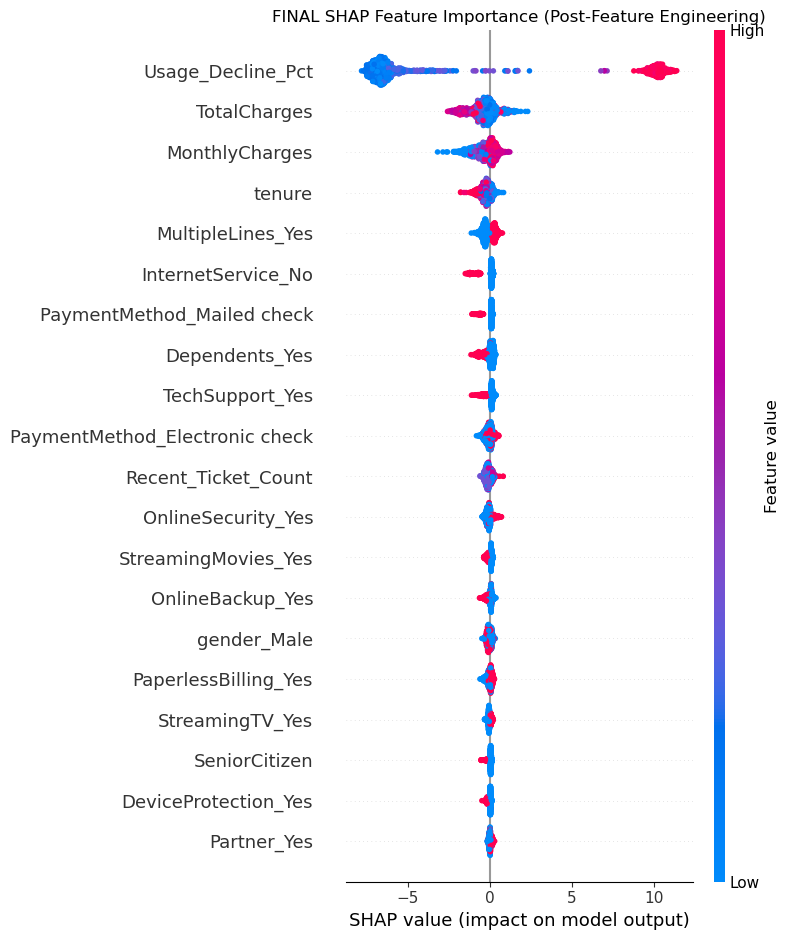

In [13]:
# --- CELL 11: FINAL SHAP ANALYSIS (With the High-Scoring Model) ---
import shap
import matplotlib.pyplot as plt

# The model object is now the highly accurate one from Cell 10
# 1. Initialize the SHAP Explainer
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 3. Create the Summary Plot (Feature Importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("FINAL SHAP Feature Importance (Post-Feature Engineering)")
plt.tight_layout()
plt.savefig('final_shap_feature_importance.png')

print("--- FINAL SHAP Analysis Complete ---")
print("Examine the new chart to see the final hierarchy of churn drivers.")

# Get a simple list of the top features (Mean absolute SHAP value)
feature_impact = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Value': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_Value', ascending=False)

print("\n--- Top 5 Churn Drivers (For Resume/Interview) ---")
print(feature_impact.head(5).to_markdown(index=False, numalign="left", stralign="left"))

In [14]:
# --- CELL 12: SAVING THE MODEL AND FEATURE LIST ---
import pickle

# 1. Save the Trained XGBoost Model (model)
model_filename = 'churn_prediction_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# 2. Save the list of feature columns (X.columns) used to train the model
# The app will need this list to encode new data the exact same way
feature_list_filename = 'model_feature_list.pkl'
with open(feature_list_filename, 'wb') as file:
    pickle.dump(X.columns.tolist(), file)

print("--- Model Artifacts Saved ---")
print(f"Model saved as: {model_filename}")
print(f"Feature list saved as: {feature_list_filename}")

--- Model Artifacts Saved ---
Model saved as: churn_prediction_model.pkl
Feature list saved as: model_feature_list.pkl


In [17]:
# --- CELL 13: SAVING THE FINAL CLEAN DATA (Simulating RDS Export) ---

# We'll re-run this to ensure the final file is saved after all the changes
# This file simulates the cleaned data coming from the RDS database

# Make sure you have the final DataFrame 'df' available in your notebook session
final_columns = [
    'customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 
    'InternetService', 'PaymentMethod', 'Recent_Ticket_Count', 
    'Usage_Decline_Pct', 'Churn_Numeric', 'Churn'
]

# Ensure only essential columns are in the final saved CSV
df_final_export = df[final_columns]

# Save the file. You may need to manually create a 'data/clean/' folder inside your project directory!
df_final_export.to_csv('data/clean/final_customer_data.csv', index=False)

print("--- Data Export Complete ---")
print("Saved final, clean data for Power BI connection as 'data/clean/final_customer_data.csv'")

--- Data Export Complete ---
Saved final, clean data for Power BI connection as 'data/clean/final_customer_data.csv'


In [2]:
import pandas as pd  

# load your clean dataset
df = pd.read_csv("data/clean/final_customer_data.csv")

# 1. Check for nulls
print(df.isnull().sum())

# 2. Quick shape & dtypes
print(df.shape)
print(df.dtypes)

# 3. Unique values in Churn mapping
print(df[['Churn', 'Churn_Numeric']].drop_duplicates())

# 4. Quick sanity stats
print(df.describe(include='all'))


customerID             0
tenure                 0
MonthlyCharges         0
TotalCharges           0
Contract               0
InternetService        0
PaymentMethod          0
Recent_Ticket_Count    0
Usage_Decline_Pct      0
Churn_Numeric          0
Churn                  0
dtype: int64
(7043, 11)
customerID              object
tenure                   int64
MonthlyCharges         float64
TotalCharges           float64
Contract                object
InternetService         object
PaymentMethod           object
Recent_Ticket_Count      int64
Usage_Decline_Pct      float64
Churn_Numeric            int64
Churn                   object
dtype: object
  Churn  Churn_Numeric
0    No              0
2   Yes              1
        customerID       tenure  MonthlyCharges  TotalCharges        Contract  \
count         7043  7043.000000     7043.000000   7043.000000            7043   
unique        7043          NaN             NaN           NaN               3   
top     3186-AJIEK          NaN   